d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1878: RuntimeWarning: overflow encountered in multiply
  result = np.conjugate(result) * result
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1878: RuntimeWarning: invalid value encountered in multiply
  result = np.conjugate(result) * result
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1880: RuntimeWarning: invalid value encountered in multiply
  result *= scale
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1886: RuntimeWarning: invalid value encountered in multiply
  result[..., 1:-1] *= 2
d:\anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1947: RuntimeWarning: invalid value encountered in multiply
  result = win * result
C:\Users\57139\AppData\Local\Temp\ipykernel_42336\1274920790.py:31: RuntimeWarning: inva

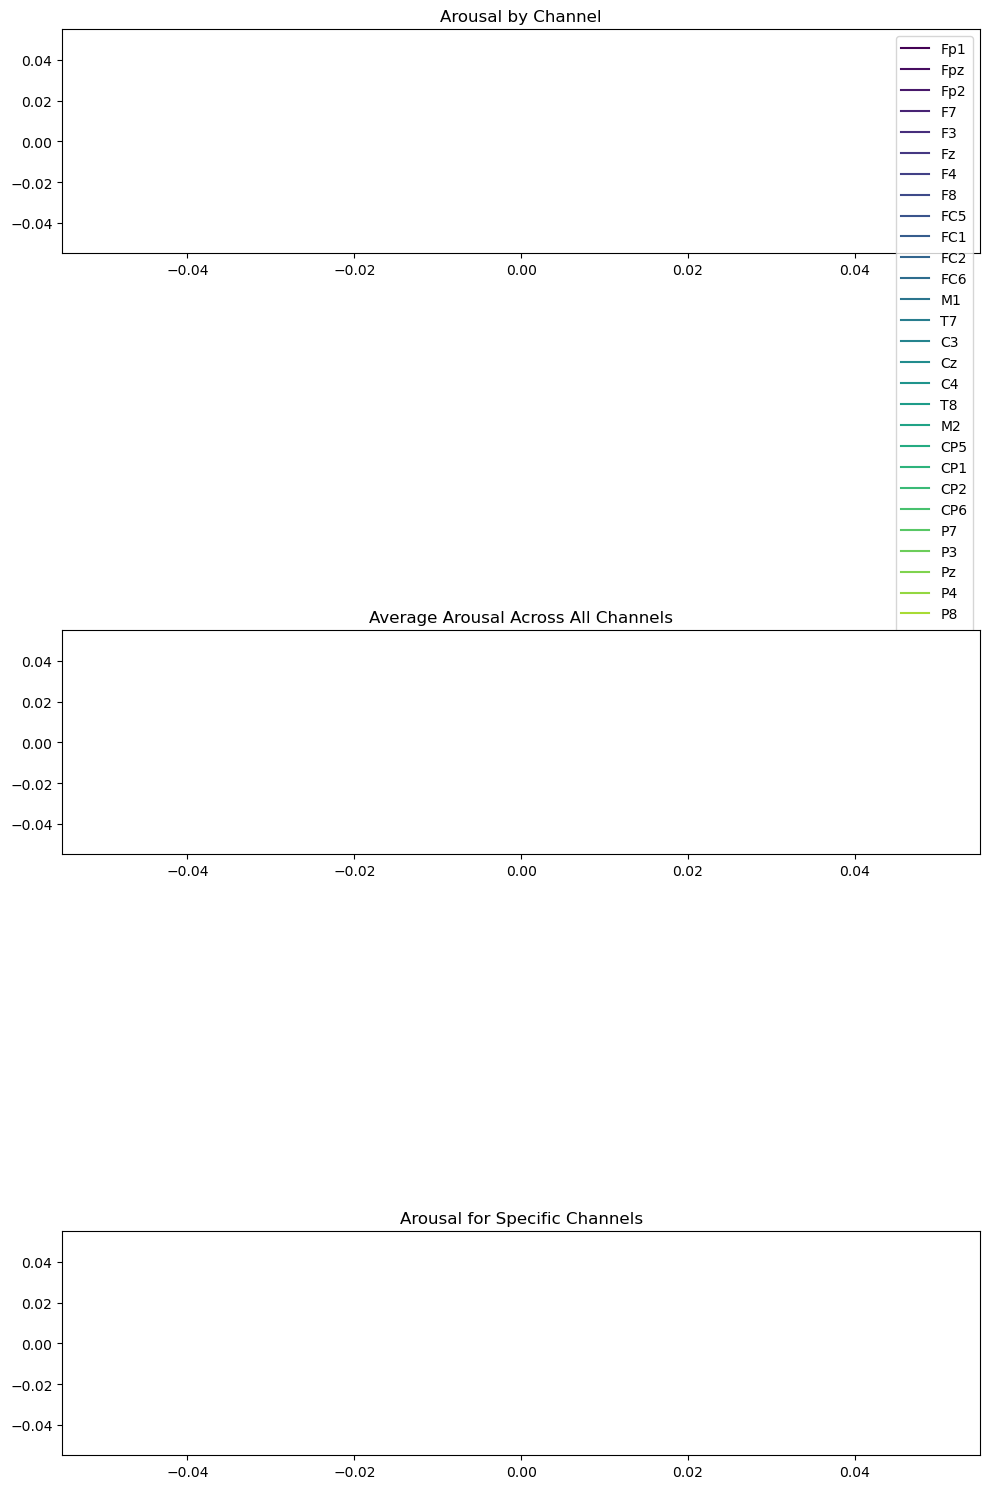

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')
timestamps = data['timestamp']

# Define band limits
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

# Sampling frequency
sfreq = 1000  # Example value, adjust based on your data specifics

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=512)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    arousal = (band_psd['alpha'] + band_psd['beta']) / (band_psd['theta'] + band_psd['delta'])
    return arousal

# Process each channel
arousals = {}
for column in data.columns[1:-4]:  # Adjust the slice to include EEG channels only
    filtered_data = bandpass_filter(data[column].values)
    arousals[column] = [calculate_arousal(filtered_data[i:i+sfreq]) for i in range(0, len(filtered_data), sfreq)]

# Calculate average arousal for all channels
average_arousal = np.mean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.mean([arousals[ch] for ch in specific_channels], axis=0)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = plt.cm.viridis(np.linspace(0, 1, len(arousals)))

# Plot each channel's arousal
for idx, (ch, ar) in enumerate(arousals.items()):
    axs[0].plot(timestamps[::sfreq], ar, label=ch, color=colors[idx])
axs[0].set_title('Arousal by Channel')
axs[0].legend()

# Plot average arousal
axs[1].plot(timestamps[::sfreq], average_arousal, label='Average Arousal', color='red')
axs[1].set_title('Average Arousal Across All Channels')

# Plot specific channels arousal
axs[2].plot(timestamps[::sfreq], specific_arousal, label='Specific Channels Arousal', color='green')
axs[2].set_title('Arousal for Specific Channels')

plt.tight_layout()
plt.show()


C:\Users\57139\AppData\Local\Temp\ipykernel_42336\1203115758.py:22: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 830, using nperseg = 830
  warnings.warn('nperseg = {0:d} is greater than input length '


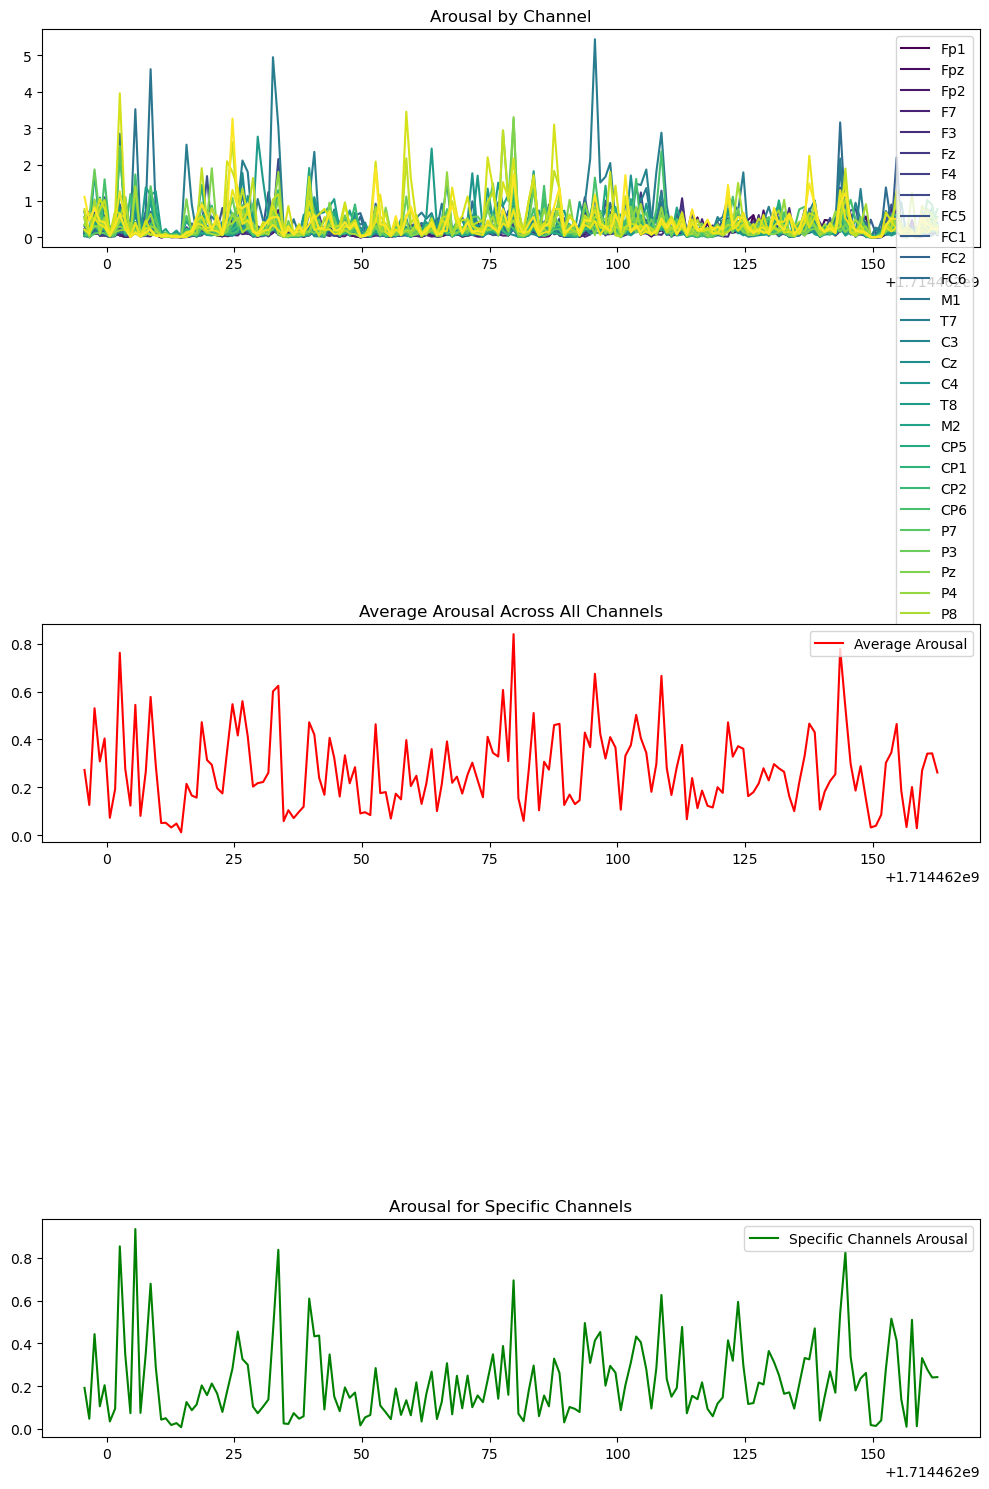

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')
timestamps = data['timestamp']

# Define band limits
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

# Sampling frequency
sfreq = 1000  # Example value, adjust based on your data specifics

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        arousal = np.nan  # Handle division by zero
    else:
        arousal = (band_psd['alpha'] + band_psd['beta']) / denominator
    return arousal

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust the slice to include EEG channels only
    data[column] = bandpass_filter(normalize_data(data[column].values))

# Process each channel
arousals = {}
for column in data.columns[1:-4]:  # Adjust the slice to include EEG channels only
    arousals[column] = [calculate_arousal(data[column].values[i:i+sfreq], fs=sfreq) for i in range(0, len(data[column].values), sfreq)]

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = plt.cm.viridis(np.linspace(0, 1, len(arousals)))

# Plot each channel's arousal
for idx, (ch, ar) in enumerate(arousals.items()):
    axs[0].plot(timestamps[::sfreq][0:len(ar)], ar, label=ch, color=colors[idx])
axs[0].set_title('Arousal by Channel')
axs[0].legend(loc='upper right')

# Plot average arousal
axs[1].plot(timestamps[::sfreq][0:len(average_arousal)], average_arousal, label='Average Arousal', color='red')
axs[1].set_title('Average Arousal Across All Channels')
axs[1].legend()

# Plot specific channels arousal
axs[2].plot(timestamps[::sfreq][0:len(specific_arousal)], specific_arousal, label='Specific Channels Arousal', color='green')
axs[2].set_title('Arousal for Specific Channels')
axs[2].legend()

plt.tight_layout()
plt.show()

C:\Users\57139\AppData\Local\Temp\ipykernel_42336\3708323846.py:26: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 830, using nperseg = 830
  warnings.warn('nperseg = {0:d} is greater than input length '


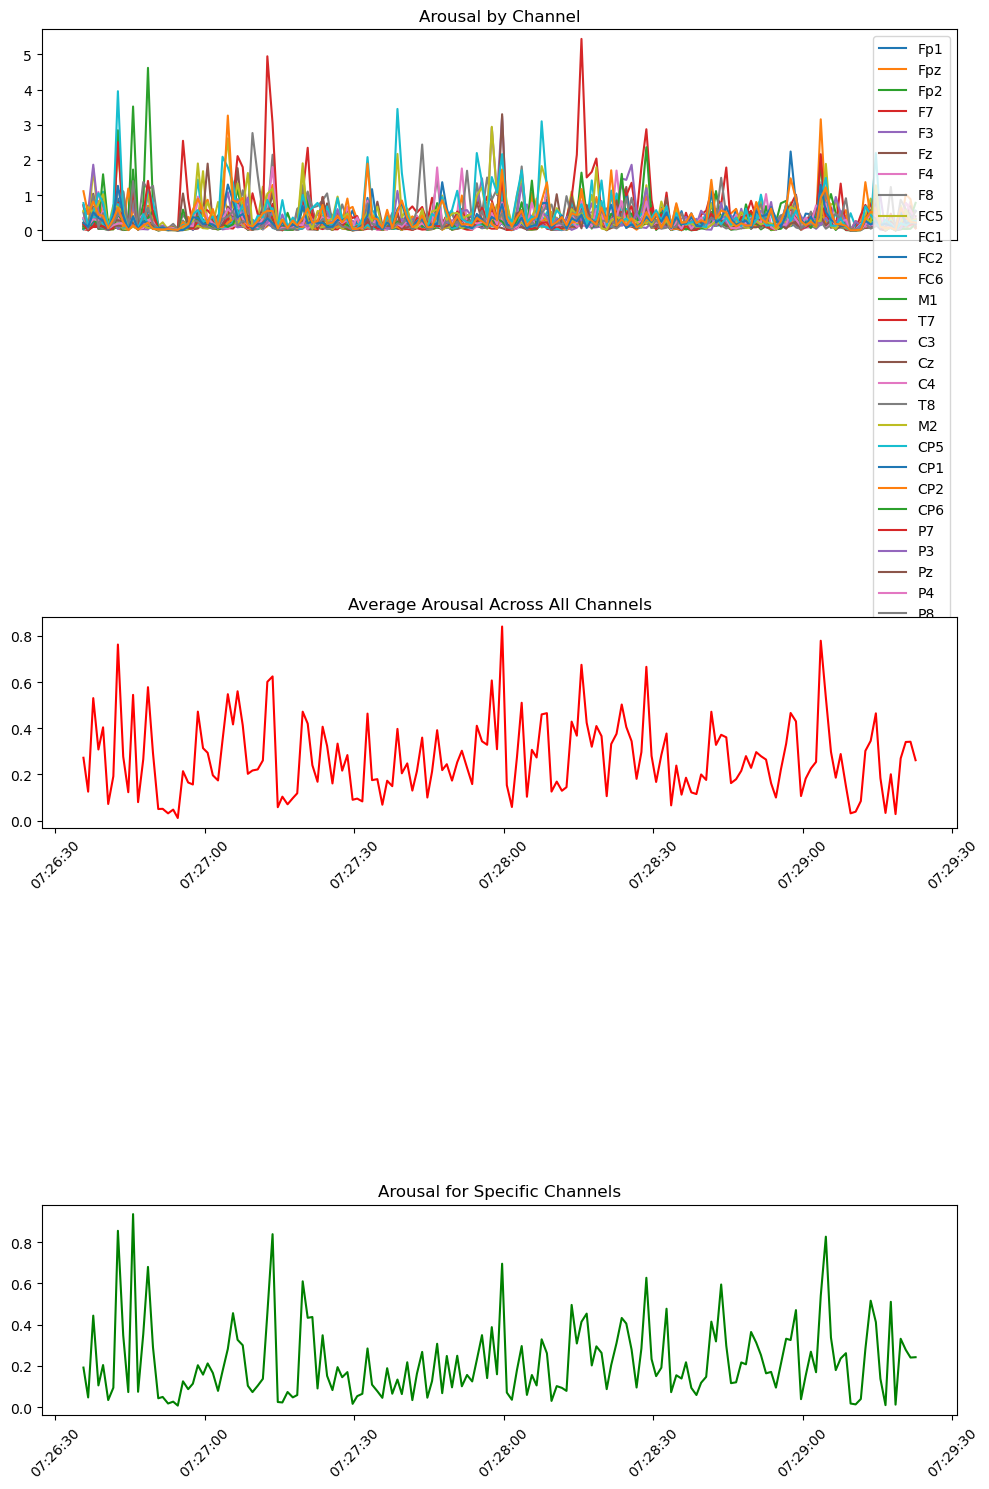

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import matplotlib.dates as mdates
from datetime import datetime

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')

# Convert UNIX timestamps to datetime objects
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

# Define band limits
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

# Sampling frequency
sfreq = 1000  # Example value, adjust based on your data specifics

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        arousal = np.nan  # Handle division by zero
    else:
        arousal = (band_psd['alpha'] + band_psd['beta']) / denominator
    return arousal

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust the slice to include EEG channels only
    data[column] = bandpass_filter(normalize_data(data[column].values))

# Process each channel
arousals = {}
for column in data.columns[1:-4]:  # Adjust the slice to include EEG channels only
    arousals[column] = [calculate_arousal(data[column].values[i:i+sfreq], fs=sfreq) for i in range(0, len(data[column].values), sfreq)]

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Use hour intervals
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))  # Format the datetime objects

# Plot each channel's arousal
for idx, (ch, ar) in enumerate(arousals.items()):
    axs[0].plot(data['timestamp'][::sfreq][0:len(ar)], ar, label=ch)
axs[0].set_title('Arousal by Channel')
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='x', rotation=45)

# Plot average arousal
axs[1].plot(data['timestamp'][::sfreq][0:len(average_arousal)], average_arousal, color='red')
axs[1].set_title('Average Arousal Across All Channels')
axs[1].tick_params(axis='x', rotation=45)

# Plot specific channels arousal
axs[2].plot(data['timestamp'][::sfreq][0:len(specific_arousal)], specific_arousal, color='green')
axs[2].set_title('Arousal for Specific Channels')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\57139\AppData\Local\Temp\ipykernel_42336\3434422558.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


<module 'matplotlib.pyplot' from 'd:\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

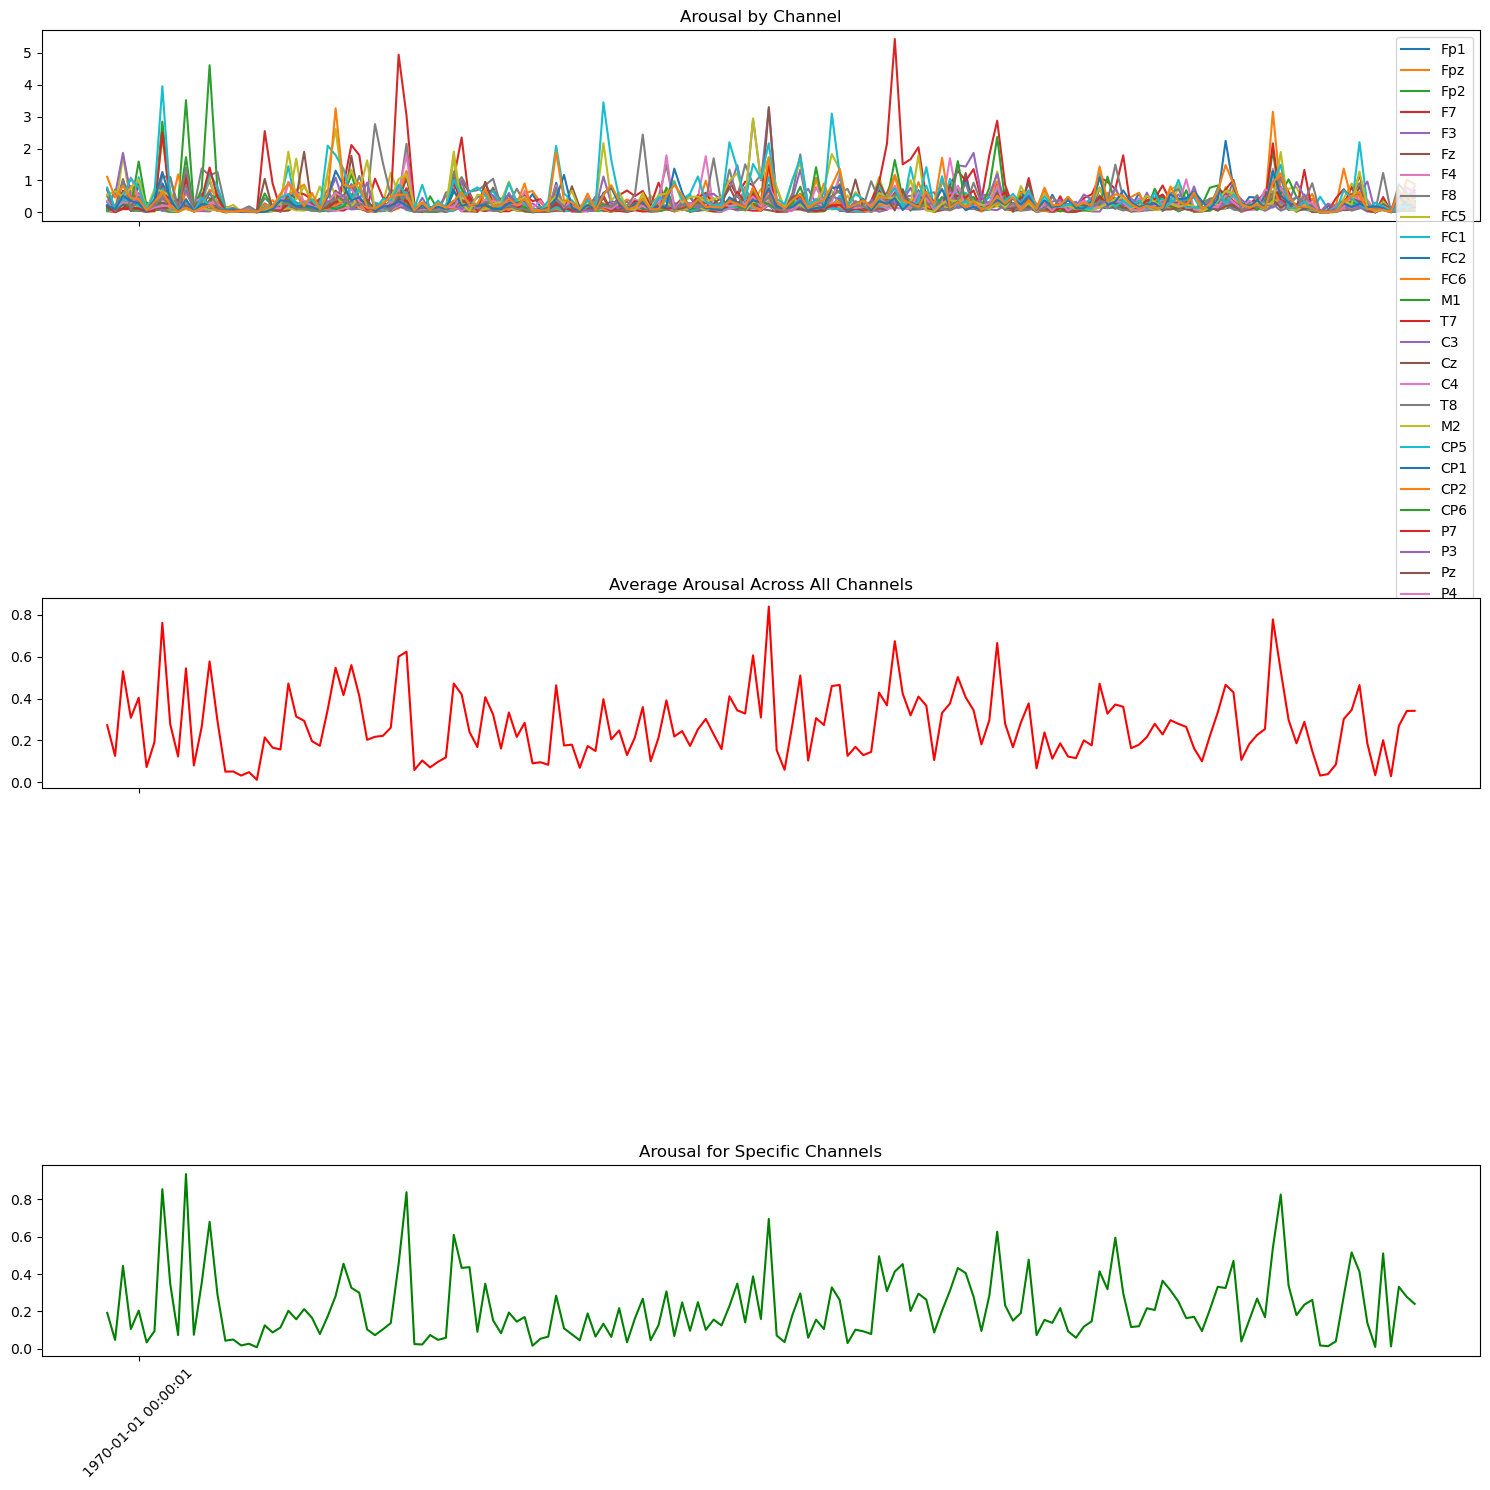

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import matplotlib.dates as mdates

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')

# Ensure timestamp is in the correct format; if UNIX epoch, use unit='s', otherwise specify the format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')  # Adjust the format

# Sampling frequency and band limits
sfreq = 1000  # Example value, confirm with your dataset
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        return np.nan  # Handle division by zero
    return (band_psd['alpha'] + band_psd['beta']) / denominator

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust this to select only EEG channels
    data[column] = normalize_data(data[column].values)
    data[column] = bandpass_filter(data[column])

# Process each channel
arousals = {}
for column in data.columns[1:-4]:
    segments = [calculate_arousal(data[column].values[i:i+sfreq], sfreq) for i in range(0, len(data[column].values) - sfreq + 1, sfreq)]
    arousals[column] = segments

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Prepare timestamps for plotting (aligning timestamps to the middle of each segment)
plot_timestamps = data['timestamp'][sfreq//2::sfreq][:len(average_arousal)]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
formatter = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
locator = mdates.AutoDateLocator()

# Plot each channel's arousal
for ch, ar in arousals.items():
    axs[0].plot(plot_timestamps[:len(ar)], ar, label=ch)
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_title('Arousal by Channel')
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='x', rotation=45)

# Plot average arousal
axs[1].plot(plot_timestamps, average_arousal, color='red')
axs[1].set_title('Average Arousal Across All Channels')
axs[1].tick_params(axis='x', rotation=45)

# Plot specific channels arousal
axs[2].plot(plot_timestamps, specific_arousal, color='green')
axs[2].set_title('Arousal for Specific Channels')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt

C:\Users\57139\AppData\Local\Temp\ipykernel_42336\218337137.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


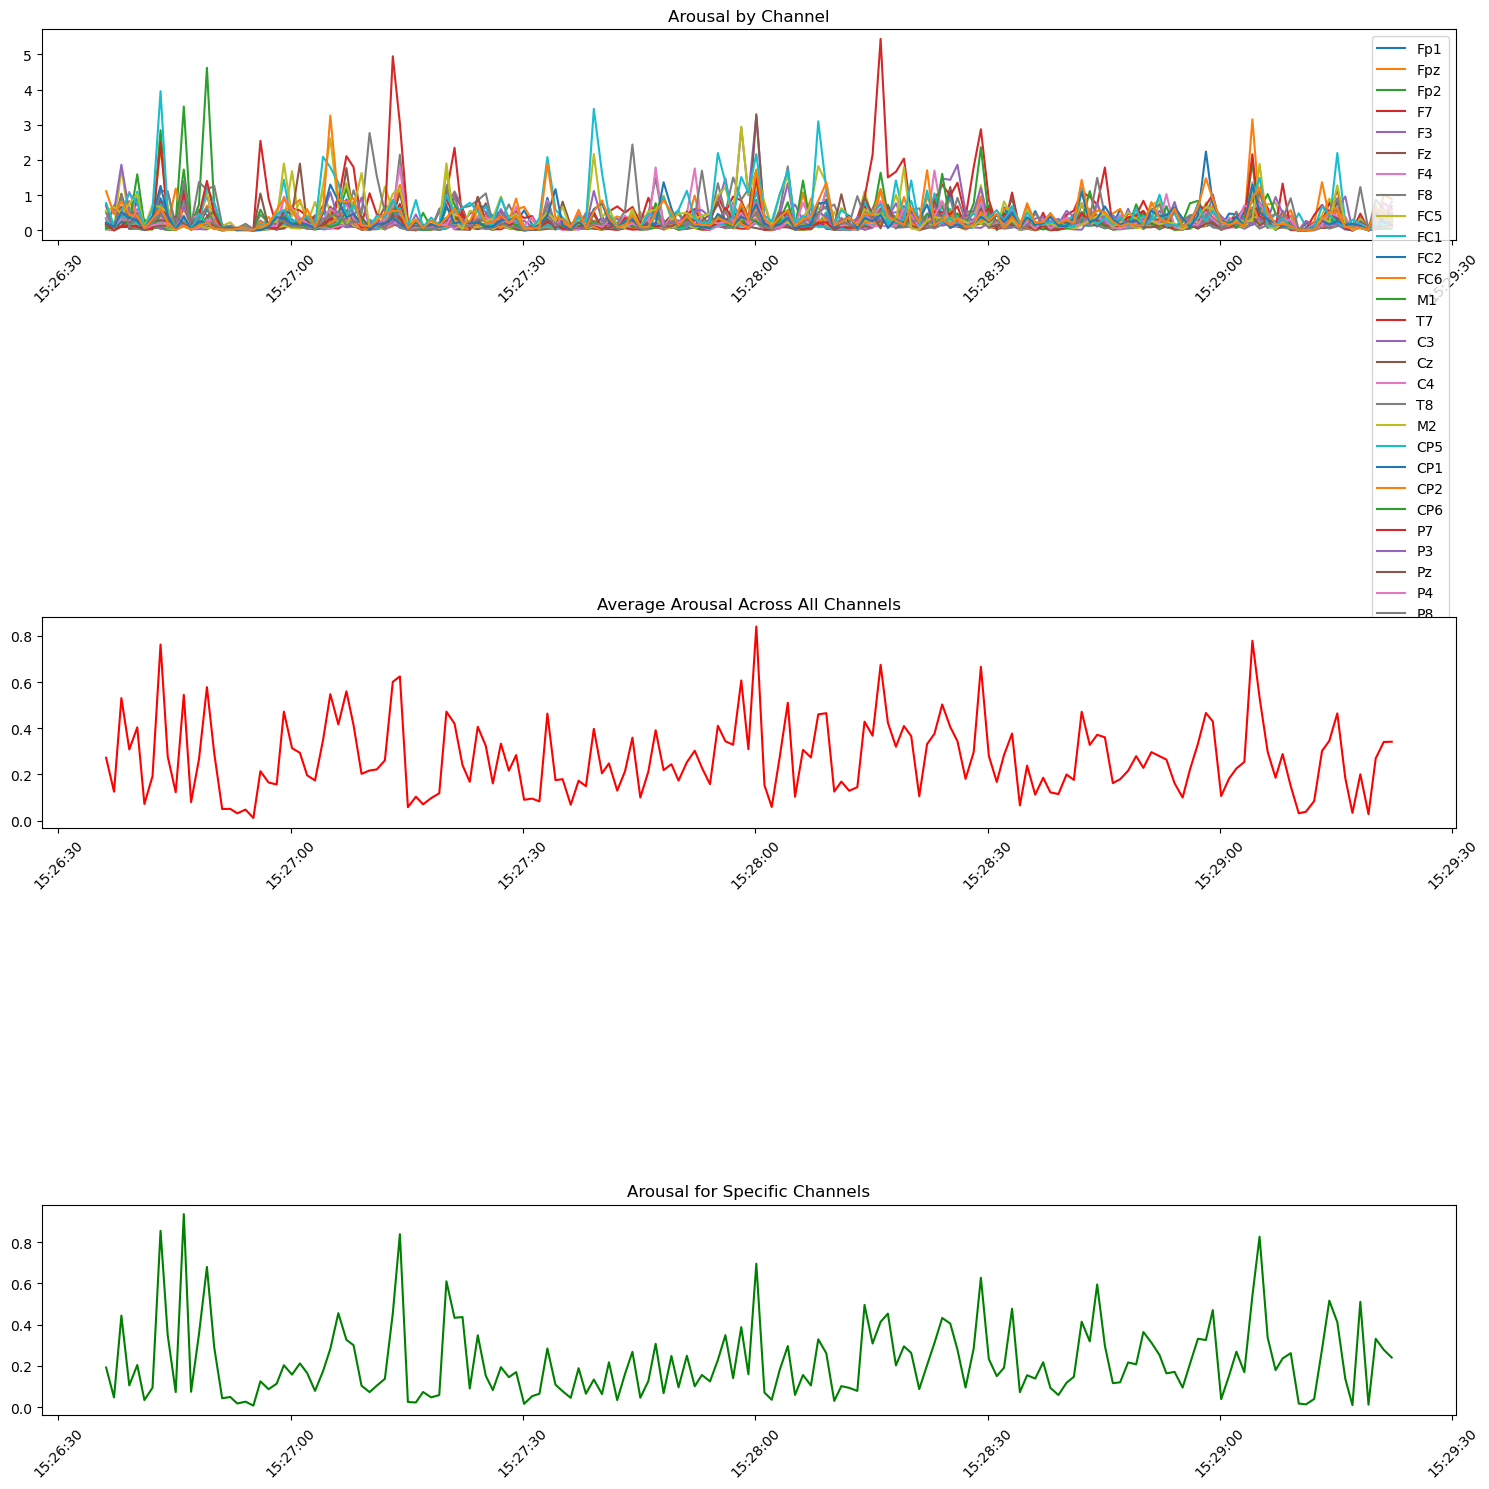

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import matplotlib.dates as mdates

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')

# Convert UNIX timestamps to datetime in Asia/Shanghai timezone and then remove timezone awareness
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

# Sampling frequency and band limits
sfreq = 1000  # Example value, confirm with your dataset
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        return np.nan  # Handle division by zero
    return (band_psd['alpha'] + band_psd['beta']) / denominator

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust this to select only EEG channels
    data[column] = normalize_data(data[column].values)
    data[column] = bandpass_filter(data[column])

# Process each channel
arousals = {}
for column in data.columns[1:-4]:
    segments = [calculate_arousal(data[column].values[i:i+sfreq], sfreq) for i in range(0, len(data[column].values) - sfreq + 1, sfreq)]
    arousals[column] = segments

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Prepare timestamps for plotting (aligning timestamps to the middle of each segment)
plot_timestamps = data['timestamp'][sfreq//2::sfreq][:len(average_arousal)]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

# Set DateFormatter for the x-axis to show hours, minutes, and seconds
formatter = mdates.DateFormatter('%H:%M:%S')
locator = mdates.AutoDateLocator()

for ax in axs:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Plot each channel's arousal
for ch, ar in arousals.items():
    axs[0].plot(plot_timestamps[:len(ar)], ar, label=ch)
axs[0].set_title('Arousal by Channel')
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='x', rotation=45)

# Plot average arousal
axs[1].plot(plot_timestamps, average_arousal, color='red')
axs[1].set_title('Average Arousal Across All Channels')
axs[1].tick_params(axis='x', rotation=45)

# Plot specific channels arousal
axs[2].plot(plot_timestamps, specific_arousal, color='green')
axs[2].set_title('Arousal for Specific Channels')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

C:\Users\57139\AppData\Local\Temp\ipykernel_42336\1366059986.py:23: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


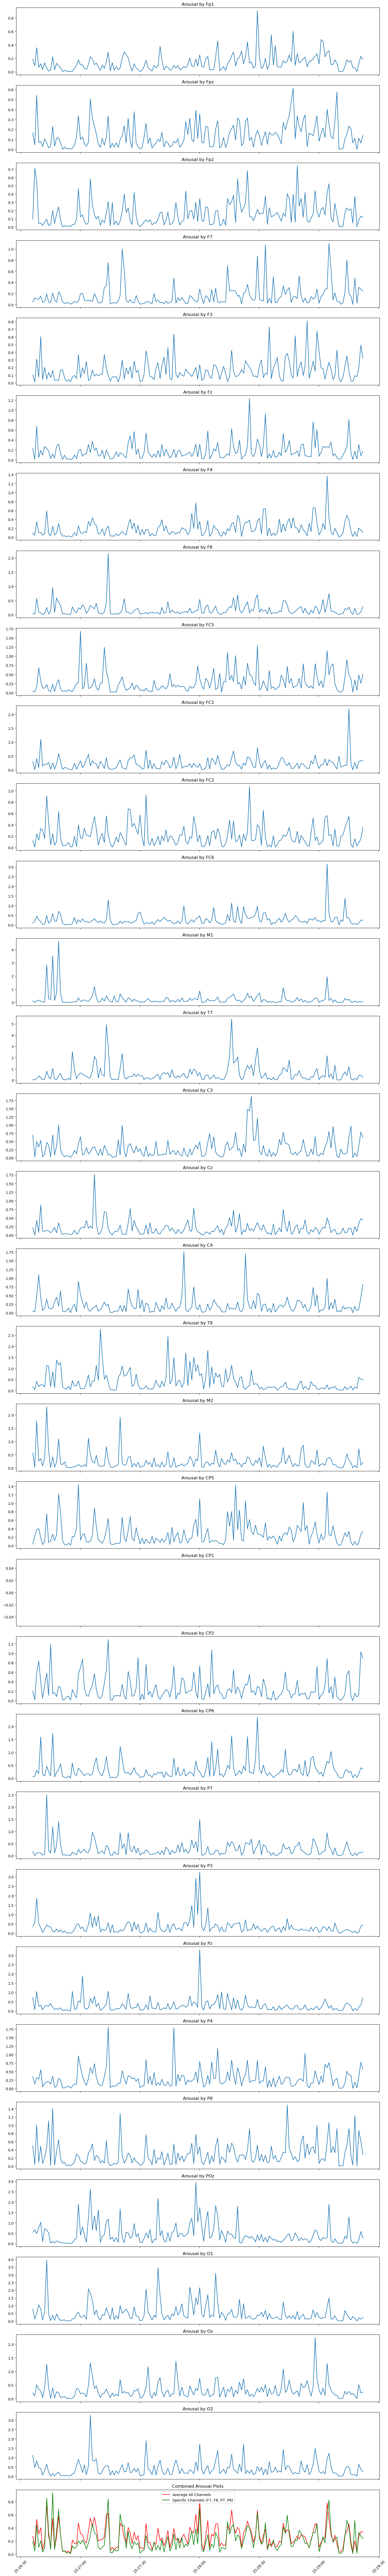

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import matplotlib.dates as mdates

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')

# Convert UNIX timestamps to datetime in Asia/Shanghai timezone and then remove timezone awareness
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

# Sampling frequency and band limits
sfreq = 1000  # Example value, confirm with your dataset
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        return np.nan  # Handle division by zero
    return (band_psd['alpha'] + band_psd['beta']) / denominator

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust this to select only EEG channels
    data[column] = normalize_data(data[column].values)
    data[column] = bandpass_filter(data[column])

# Process each channel
arousals = {}
for column in data.columns[1:-4]:
    segments = [calculate_arousal(data[column].values[i:i+sfreq], sfreq) for i in range(0, len(data[column].values) - sfreq + 1, sfreq)]
    arousals[column] = segments

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Prepare timestamps for plotting
plot_timestamps = data['timestamp'][sfreq//2::sfreq][:len(average_arousal)]

# Plotting
fig, axs = plt.subplots(len(arousals) + 1, 1, figsize=(15, 3 * (len(arousals) + 1)), sharex=True)

# Set DateFormatter for the x-axis
formatter = mdates.DateFormatter('%H:%M:%S')
locator = mdates.AutoDateLocator()
for ax in axs:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Plot each channel's arousal
for idx, (ch, ar) in enumerate(arousals.items()):
    axs[idx].plot(plot_timestamps[:len(ar)], ar, label=f'Arousal - {ch}')
    axs[idx].set_title(f'Arousal by {ch}')
    axs[idx].tick_params(axis='x', rotation=45)

# Combined plot for average and specific channels' arousal
axs[-1].plot(plot_timestamps, average_arousal, label='Average All Channels', color='red')
axs[-1].plot(plot_timestamps, specific_arousal, label='Specific Channels (F7, F8, P7, P8)', color='green')
axs[-1].set_title('Combined Arousal Plots')
axs[-1].legend()
axs[-1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, butter, filtfilt
import matplotlib.dates as mdates
import os

# Load data
data = pd.read_csv('E:\\EEG_Neurofeedback\\data\\20240430_01_final_02\\eegraw_20240430_152635_final.csv')

# Convert UNIX timestamps to datetime in Asia/Shanghai timezone and then remove timezone awareness
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

# Sampling frequency and band limits
sfreq = 250  # Example value, confirm with your dataset
bands = {
    'delta': (1, 3),
    'theta': (4, 7),
    'alpha': (8, 12),
    'beta': (13, 30)
}

def normalize_data(data):
    return (data - np.mean(data)) / np.std(data)

def bandpass_filter(data, lowcut=1.0, highcut=40.0, fs=sfreq, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def calculate_arousal(data, fs=sfreq):
    f, psd = welch(data, fs=fs, nperseg=1024)
    band_psd = {band: np.mean(psd[(f >= low) & (f <= high)]) for band, (low, high) in bands.items()}
    denominator = (band_psd['theta'] + band_psd['delta'])
    if denominator == 0:
        return np.nan  # Handle division by zero
    return (band_psd['alpha'] + band_psd['beta']) / denominator

# Apply normalization and filtering
for column in data.columns[1:-4]:  # Adjust this to select only EEG channels
    data[column] = normalize_data(data[column].values)
    data[column] = bandpass_filter(data[column])

# Process each channel
arousals = {}
for column in data.columns[1:-4]:
    segments = [calculate_arousal(data[column].values[i:i+sfreq], sfreq) for i in range(0, len(data[column].values) - sfreq + 1, sfreq)]
    arousals[column] = segments

# Calculate average arousal for all channels
average_arousal = np.nanmean(list(arousals.values()), axis=0)

# Calculate arousal for specific channels
specific_channels = ['F7', 'F8', 'P7', 'P8']
specific_arousal = np.nanmean([arousals[ch] for ch in specific_channels], axis=0)

# Prepare timestamps for plotting
plot_timestamps = data['timestamp'][sfreq//2::sfreq][:len(average_arousal)]

# Plotting and saving figures
desktop_path = os.path.expanduser("~/Desktop")
fig, ax = plt.subplots(figsize=(15, 5))
formatter = mdates.DateFormatter('%H:%M:%S')
locator = mdates.MinuteLocator(interval=5)  # Adjust interval as needed

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.tick_params(axis='x', rotation=45)

# Combined plot for average and specific channels' arousal
ax.plot(plot_timestamps, average_arousal, label='Average All Channels', color='red')
ax.plot(plot_timestamps, specific_arousal, label='Specific Channels (F7, F8, P7, P8)', color='green')
ax.set_title('Combined Arousal Plots')
ax.legend()
plt.tight_layout()

# Save the figure
filename = os.path.join(desktop_path, 'Combined_Arousal_Plot.png')
plt.savefig(filename)
plt.close()

# Individual channel plots
for ch, ar in arousals.items():
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(plot_timestamps[:len(ar)], ar, label=f'Arousal - {ch}')
    ax.set_title(f'Arousal by {ch}')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    plt.tight_layout()

    # Save each figure
    filename = os.path.join(desktop_path, f'Arousal_{ch}.png')
    plt.savefig

C:\Users\57139\AppData\Local\Temp\ipykernel_42336\2253988000.py:24: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.mean(data)) / np.std(data)
d:\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 250, using nperseg = 250
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\57139\AppData\Local\Temp\ipykernel_42336\2253988000.py:86: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 5))
Locator attempting to generate 1052065 ticks ([10957.0, ..., 14610.0]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: 